# SCANPY - PAGA

In [1]:
##########----- Reused code -----##########
# Last update: Sept 13, 2020
# By: Huitian Diao
# Python3.8 environment: sc_py3.8
###########################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
import csv
from astropy.io import ascii
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import DBSCAN
import warnings
from pathlib import Path
from scipy import stats

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

warnings.filterwarnings('ignore')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.4 numpy==1.19.2 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/codes_local","")

    wk_dir = base_dir + "/1_Scanpy"
    Path(wk_dir).mkdir(parents=True, exist_ok=True)
    sp_name = base_dir.split("/")[-1]
    outname_base = sp_name
else:
    print("Reload")

Start


In [3]:
#--- Analysis name
analysis_name = ['0', "all"]
new_wk_dir = wk_dir + "/%s-%s_Scanpy_out"%(analysis_name[0], analysis_name[1])
Path(new_wk_dir).mkdir(parents=True, exist_ok=True)

print(sp_name, analysis_name)

1_IL2RAKO ['0', 'all']


-----

## Configuration

In [4]:
filter_celltypes = ["EndoNAV"]

min_gene_nu = 500 # Minimum gene number for cell filtering
min_cell_nu = 3 # Minimum cell number for cell filtering
max_gene_nu = 5000 # Maximum gene number for cell filtering
max_pctg_mito = 0.05 # Maximum mitocondria read percentage for cell filtering

nn_n = 20
nn_pc = 20
umap_n = 100 # Umap neighbor number
umap_pc = 50 # Umap PC number

c9_umap_n = 10
c9_umap_pc = 30

## Import data

In [5]:
os.chdir(wk_dir)

mtx_dir = base_dir + "/0_cellranger_outs_XL_folder/outs/filtered_feature_bc_matrix"  # the directory with the `.mtx` file

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
results_file = './write/%s_paga.h5ad'%outname_base  # the file that will store the analysis results
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx(mtx_dir, var_names='gene_symbols', cache=True)
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it
adata.var_names_make_unique()

os.chdir(new_wk_dir)

adata

... reading from cache file cache/media-pipkin-ROCKET-PRO-CD8_DEV_SC-1_IL2RAKO-0_cellranger_outs_XL_folder-outs-filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 2957 × 31053
    var: 'gene_ids', 'feature_types'

## 0. Pre-processing

### 0.1 Add in cell type data

In [6]:
cell_type_info = base_dir + "/0_cellranger_outs_XL_folder/Hashtag_count/Cells_Type.csv"
with open(cell_type_info, 'r') as f:
  reader = csv.reader(f)
  cell_type_list = list(reader)
cell_type_list = [x[0] for x in cell_type_list]

adata.obs["cell_type"] = cell_type_list

# Filter out ambigous cells
adata = adata[adata.obs['cell_type'] != "Ambigous", :]

### 0.2 Basic filtering & Mitochondrial filtering (Remove bad quality cells)

filtered out 98 cells that have less than 500 genes expressed


Trying to set attribute `.obs` of view, copying.


filtered out 18260 genes that are detected in less than 3 cells


Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.var` of view, copying.
... storing 'feature_types' as categorical


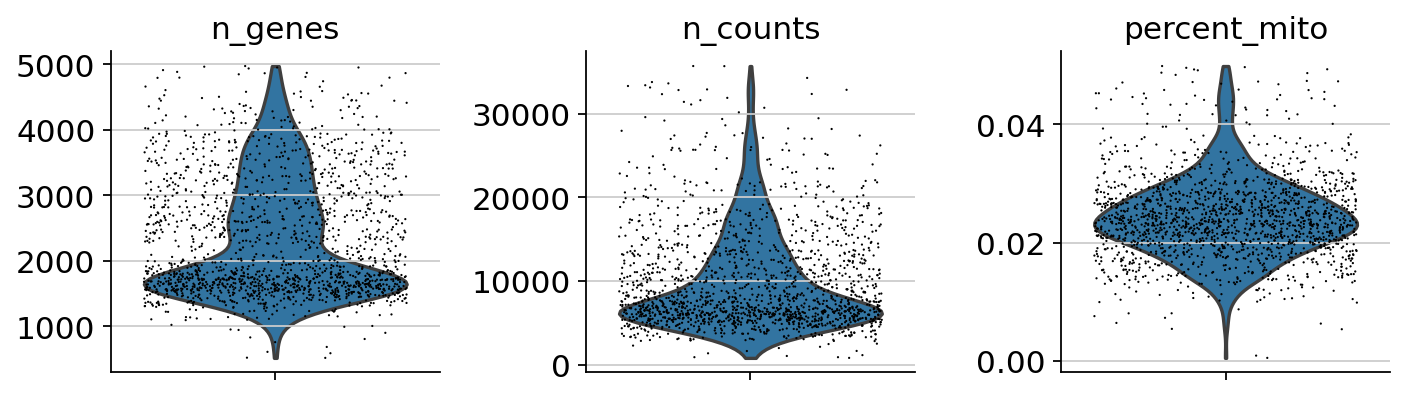

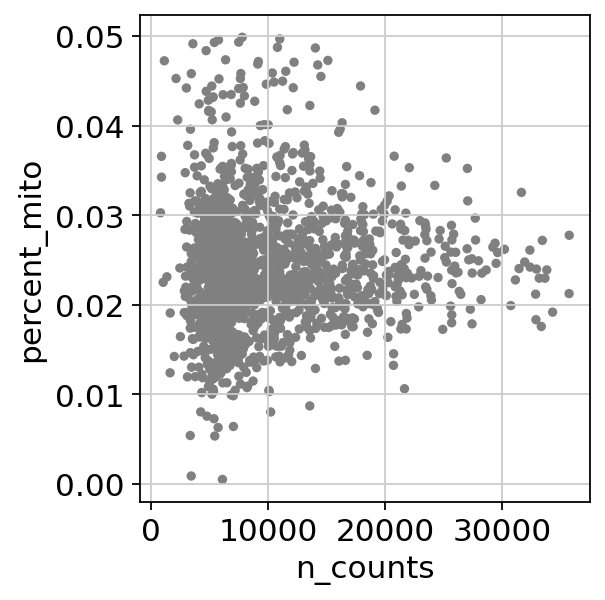

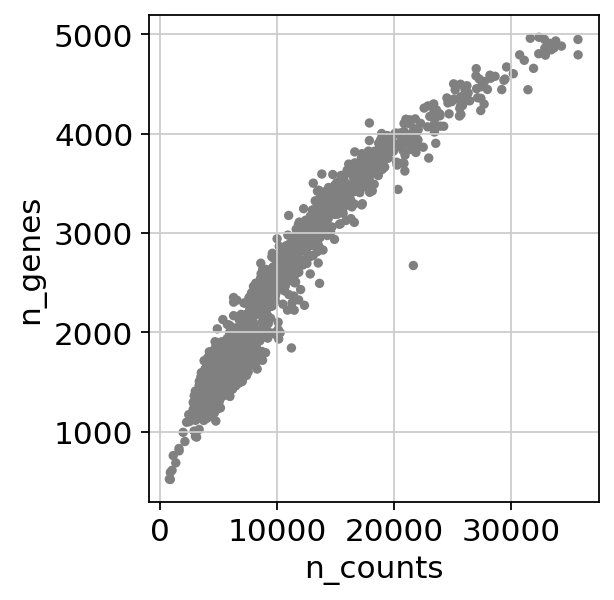

In [7]:
###----- Filter
for i in filter_celltypes:
    adata = adata[adata.obs['cell_type'] != i, :]

# Basic filtering
sc.pp.filter_cells(adata, min_genes=min_gene_nu)
sc.pp.filter_genes(adata, min_cells=min_cell_nu)

# Mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1


# Basic filtering
sc.pp.filter_cells(adata, min_genes=min_gene_nu)
sc.pp.filter_genes(adata, min_cells=min_cell_nu)
adata = adata[adata.obs['n_genes'] < max_gene_nu, :]
adata = adata[adata.obs['percent_mito'] < max_pctg_mito, :]

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### 0.3 Normalization

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


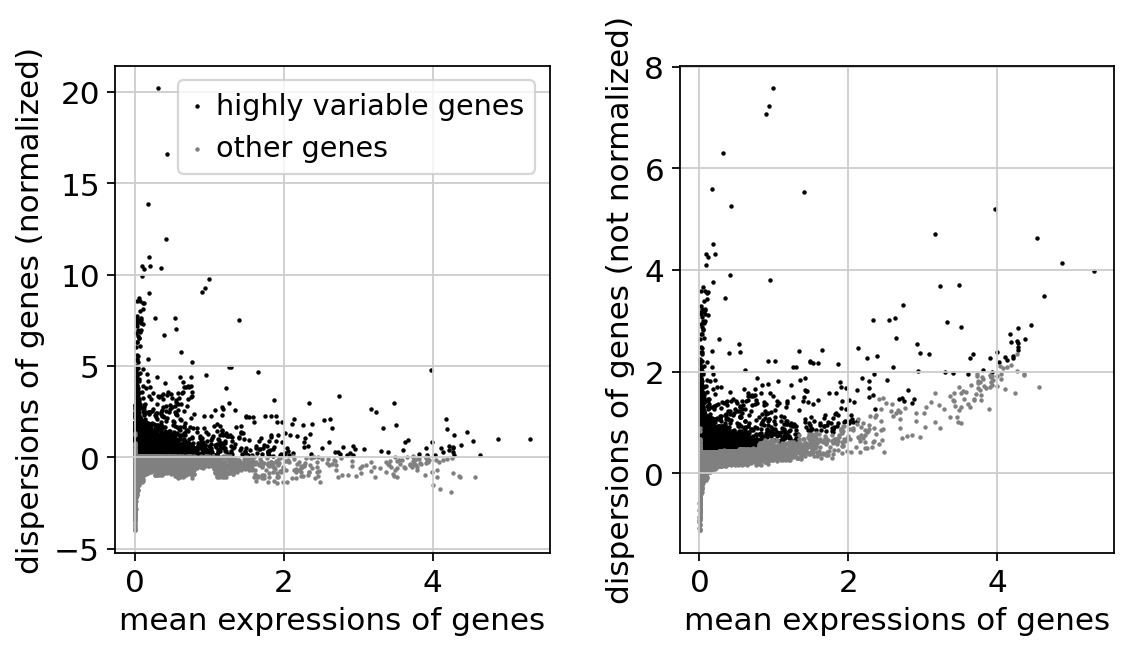

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [8]:
# Total-count normalize the data matrix to 10,000 reads per cell, so the counts become comparable among cells
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

write_flag = True
write_dir = new_wk_dir + '/counts_XL_folder'
Path(write_dir).mkdir(parents=True, exist_ok=True)

# Logarithmize the data
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.002, max_mean=10, min_disp=0.1)
sc.pl.highly_variable_genes(adata)

adata.raw = adata
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts'])
sc.pp.scale(adata, max_value=10) 

In [9]:
adata.write("%s_prePCA.h5ad"%outname_base)

-----
## Resampled Reload point

In [10]:
adata = sc.read_h5ad("%s_prePCA.h5ad"%outname_base)

## 1. Clustering and PAGA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:06)


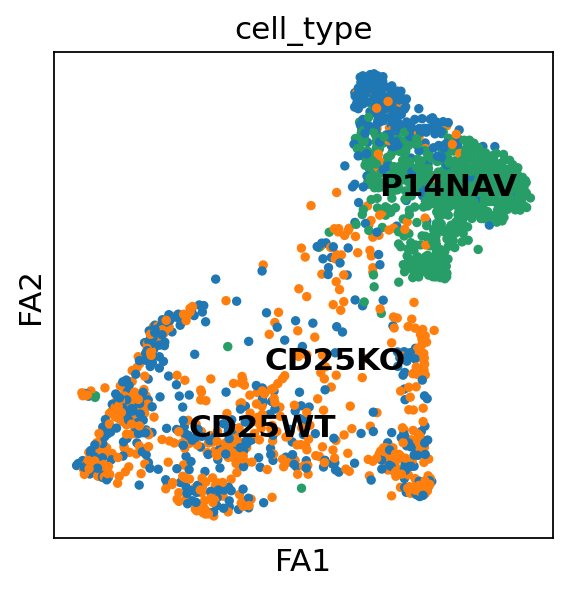

In [11]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=nn_n, n_pcs=nn_pc)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='cell_type', legend_loc='on data')

In [12]:
adata.write("%s_nn.h5ad"%outname_base)

In [13]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_nn.h5ad"%outname_base)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
----------
Counter({'0': 381, '1': 206, '2': 204, '3': 200, '4': 198, '5': 126, '6': 121, '7': 90, '8': 87, '9': 64})
----------
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


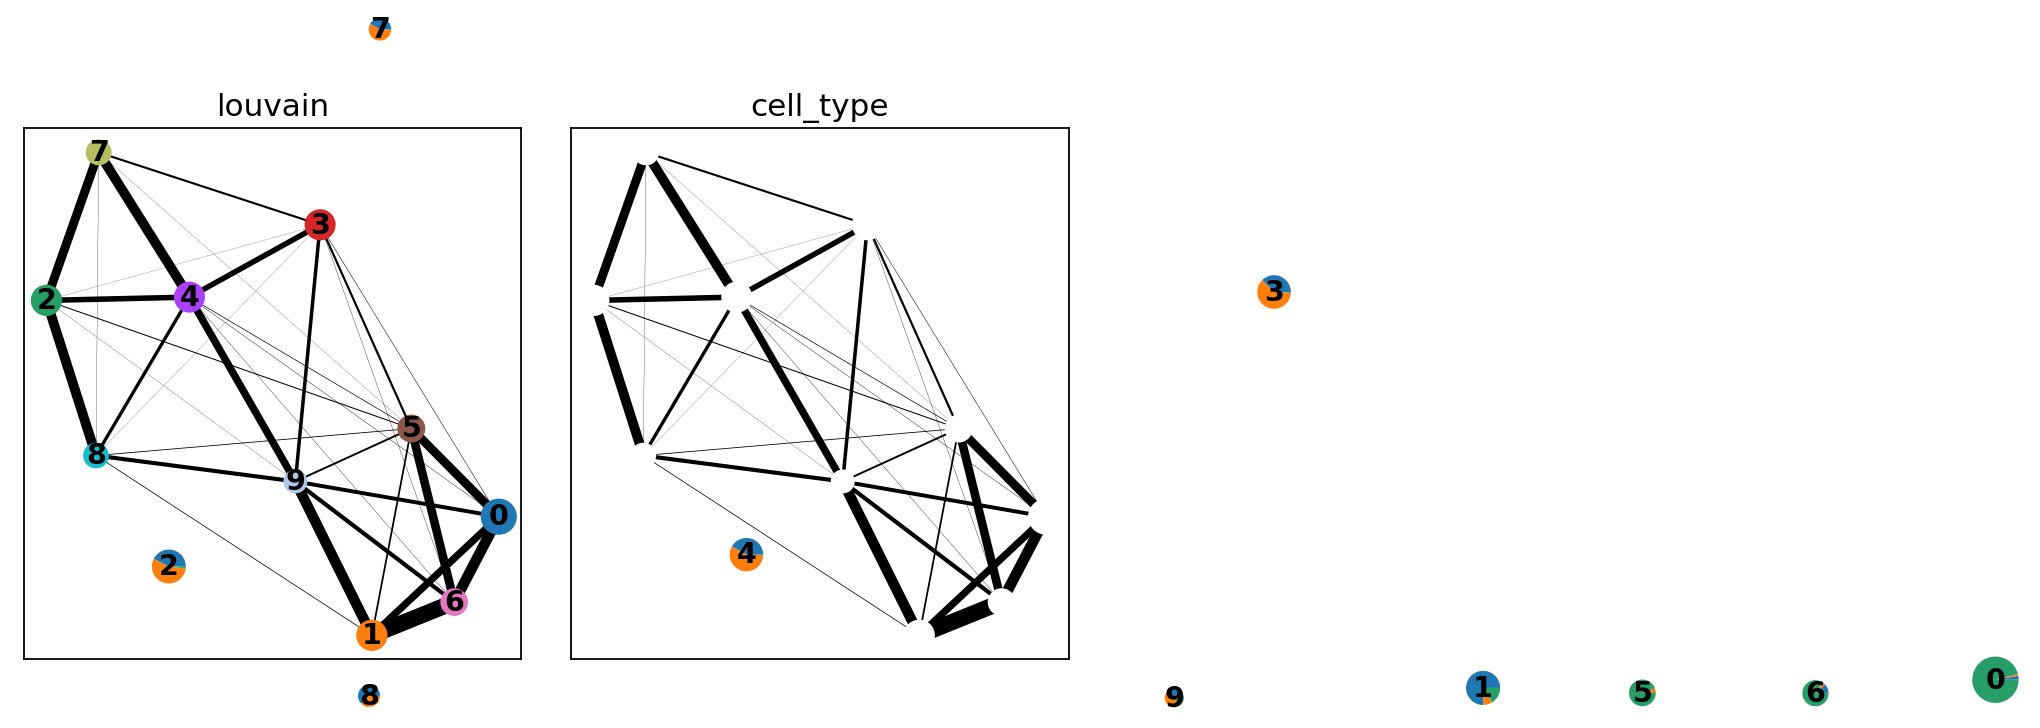

In [14]:
sc.tl.louvain(adata, resolution=1)
print("----------")
print(Counter(list(adata.obs['louvain'])))
print("----------")
sc.tl.paga(adata, groups='louvain')
sc.pl.paga(adata, color=['louvain', 'cell_type'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


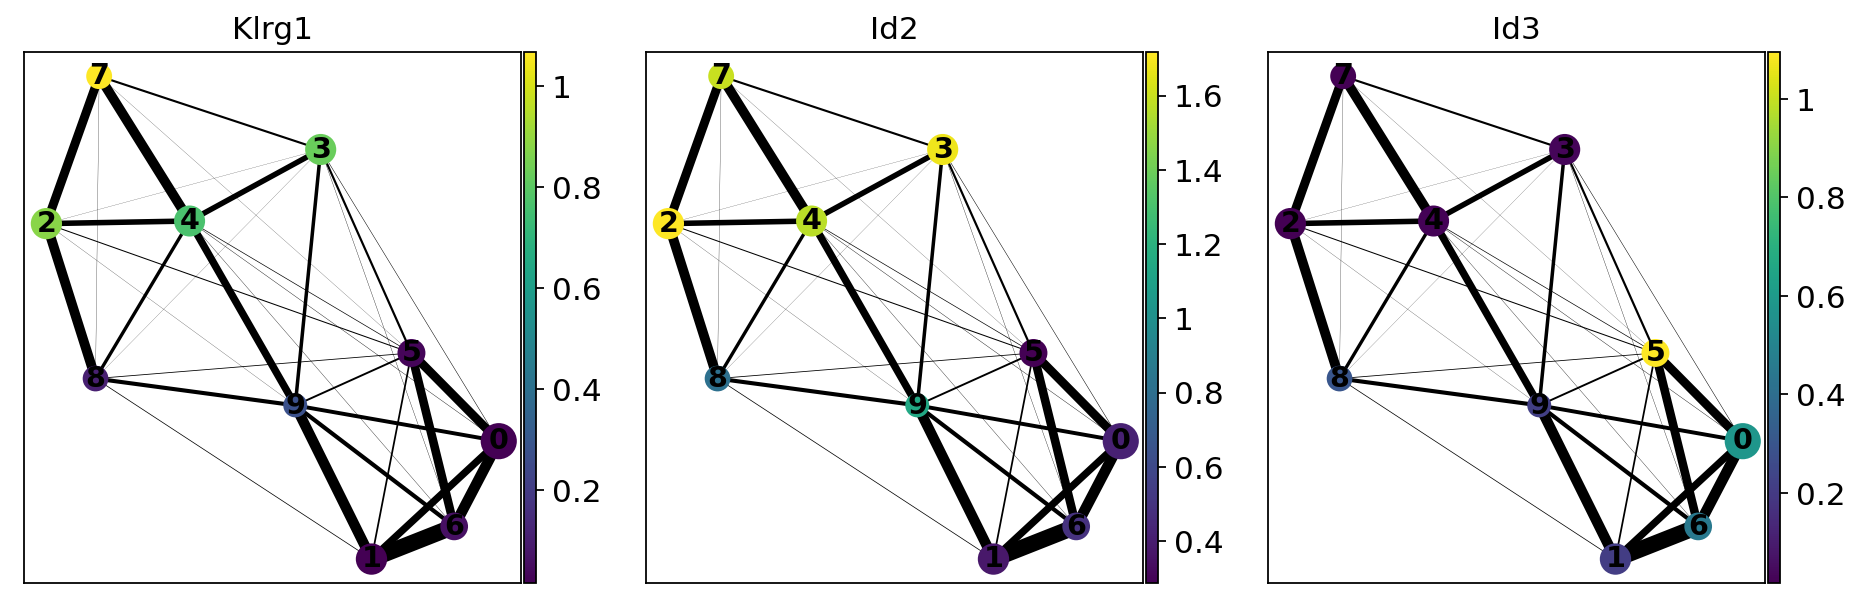

In [15]:
sc.pl.paga(adata,color=['Klrg1','Id2', 'Id3'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


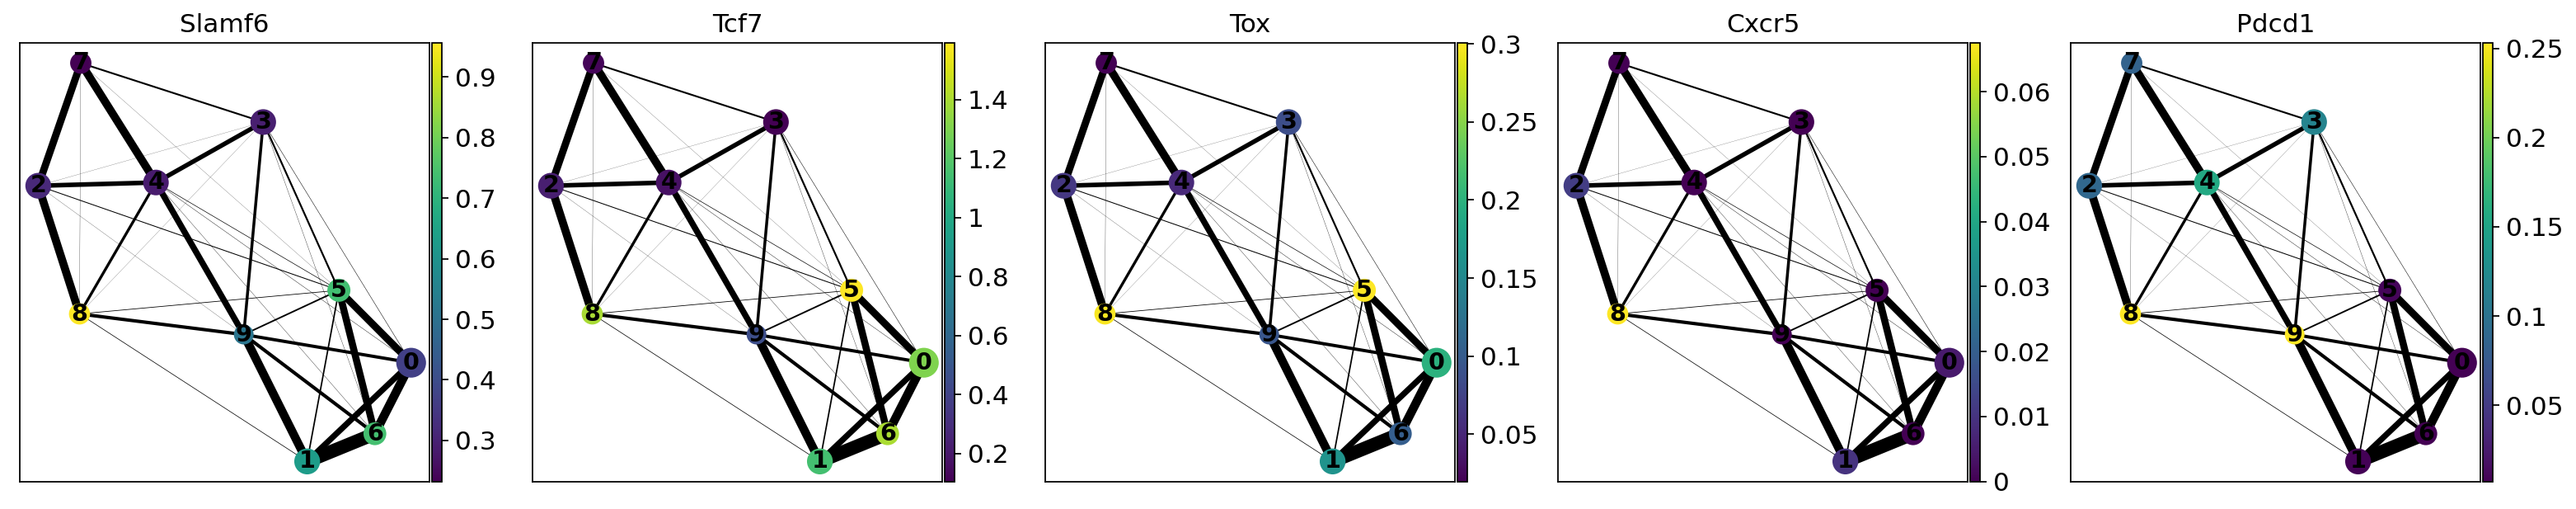

In [16]:
sc.pl.paga(adata, color=['Slamf6', 'Tcf7', 'Tox', 'Cxcr5', 'Pdcd1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


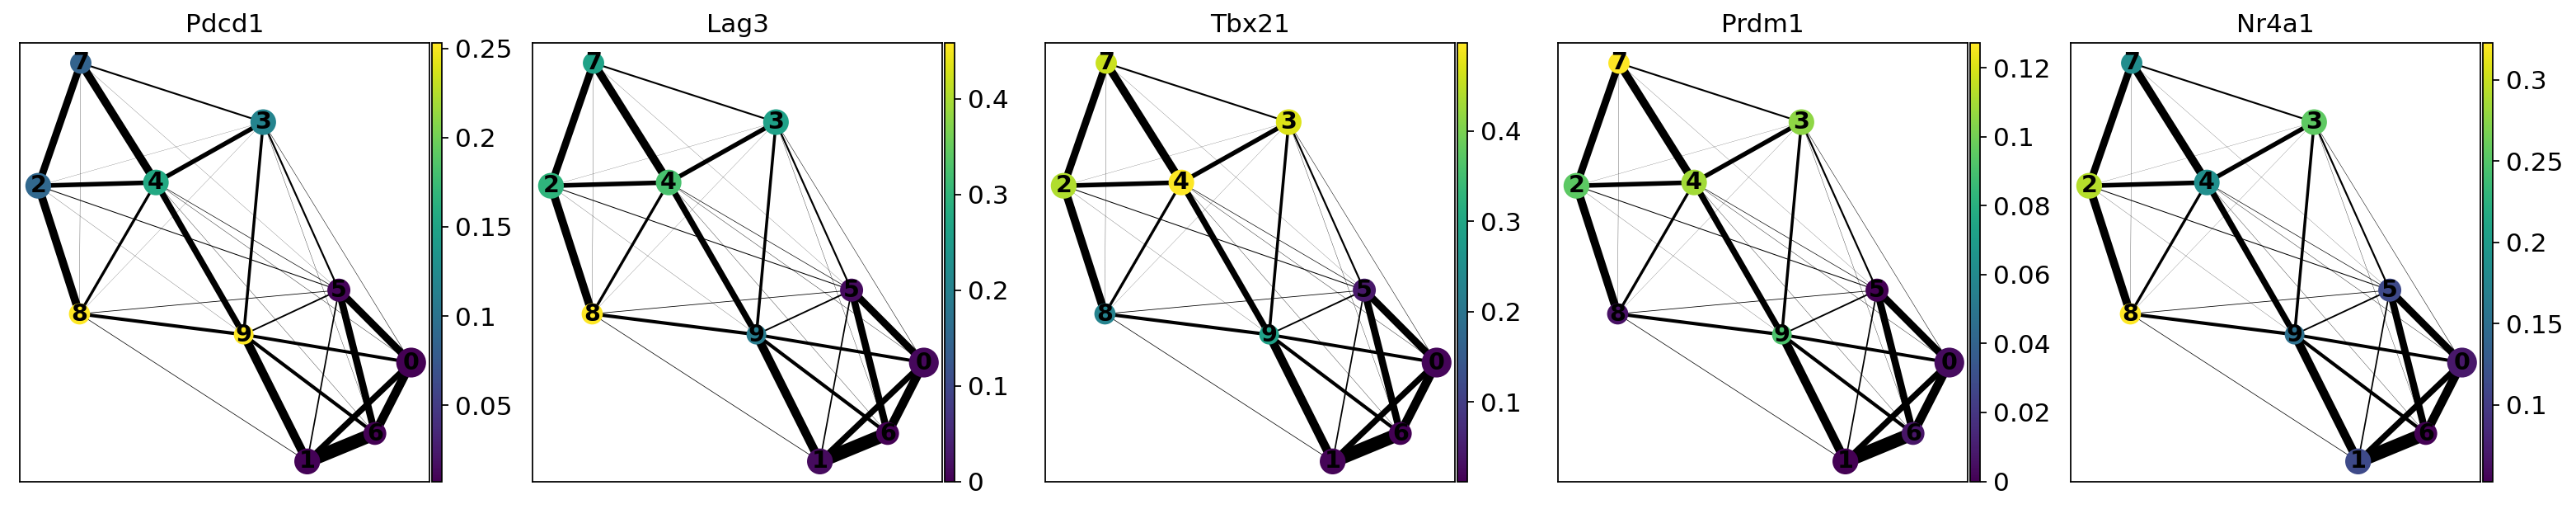

In [17]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Prdm1', 'Nr4a1'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


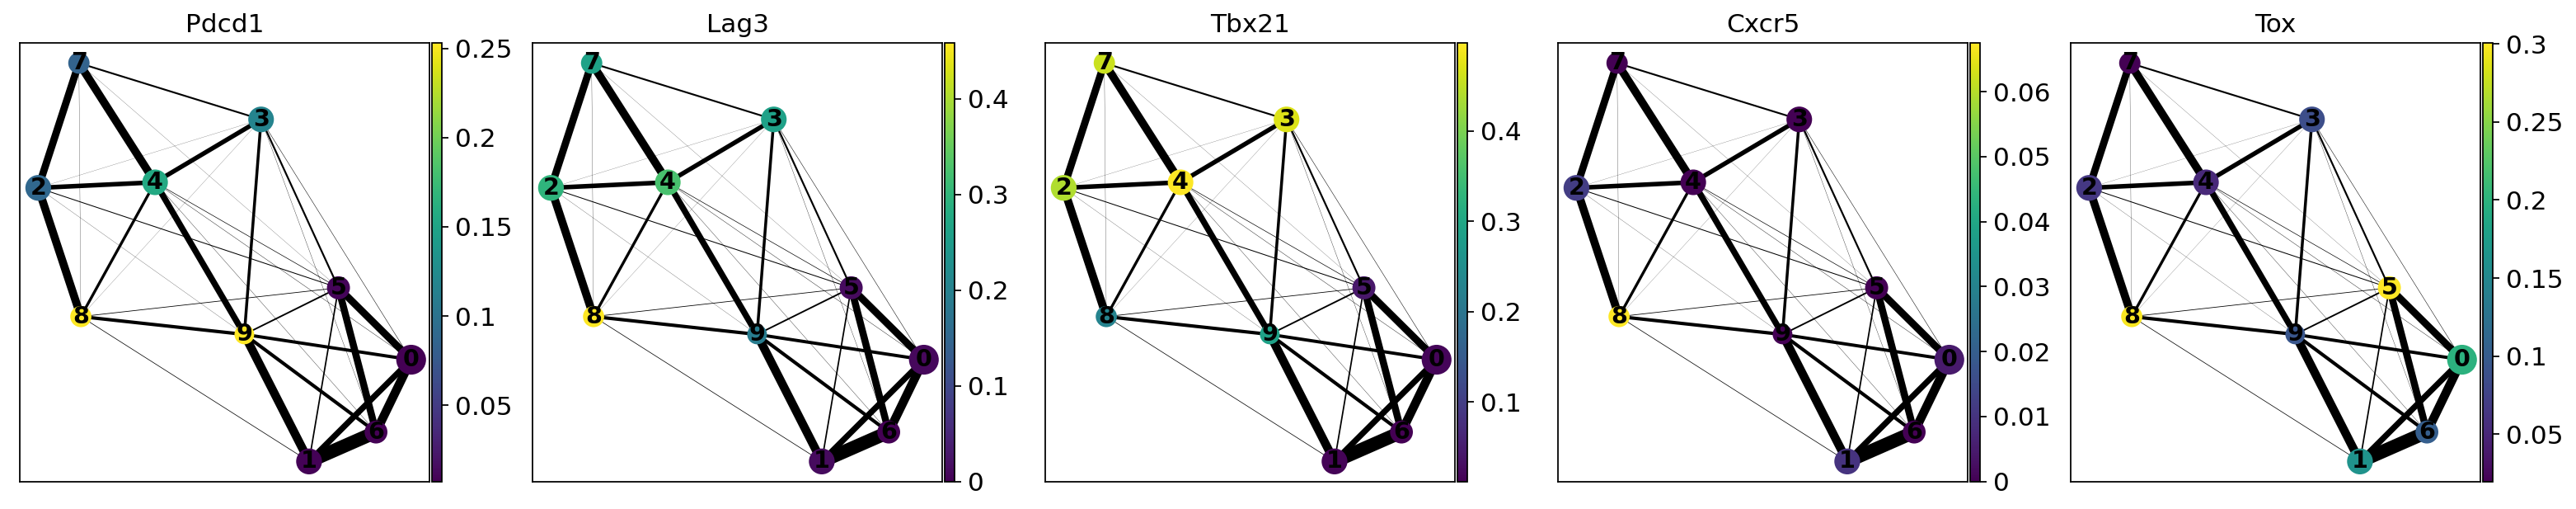

In [18]:
sc.pl.paga(adata, color=['Pdcd1',  'Lag3', 'Tbx21', 'Cxcr5', 'Tox'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


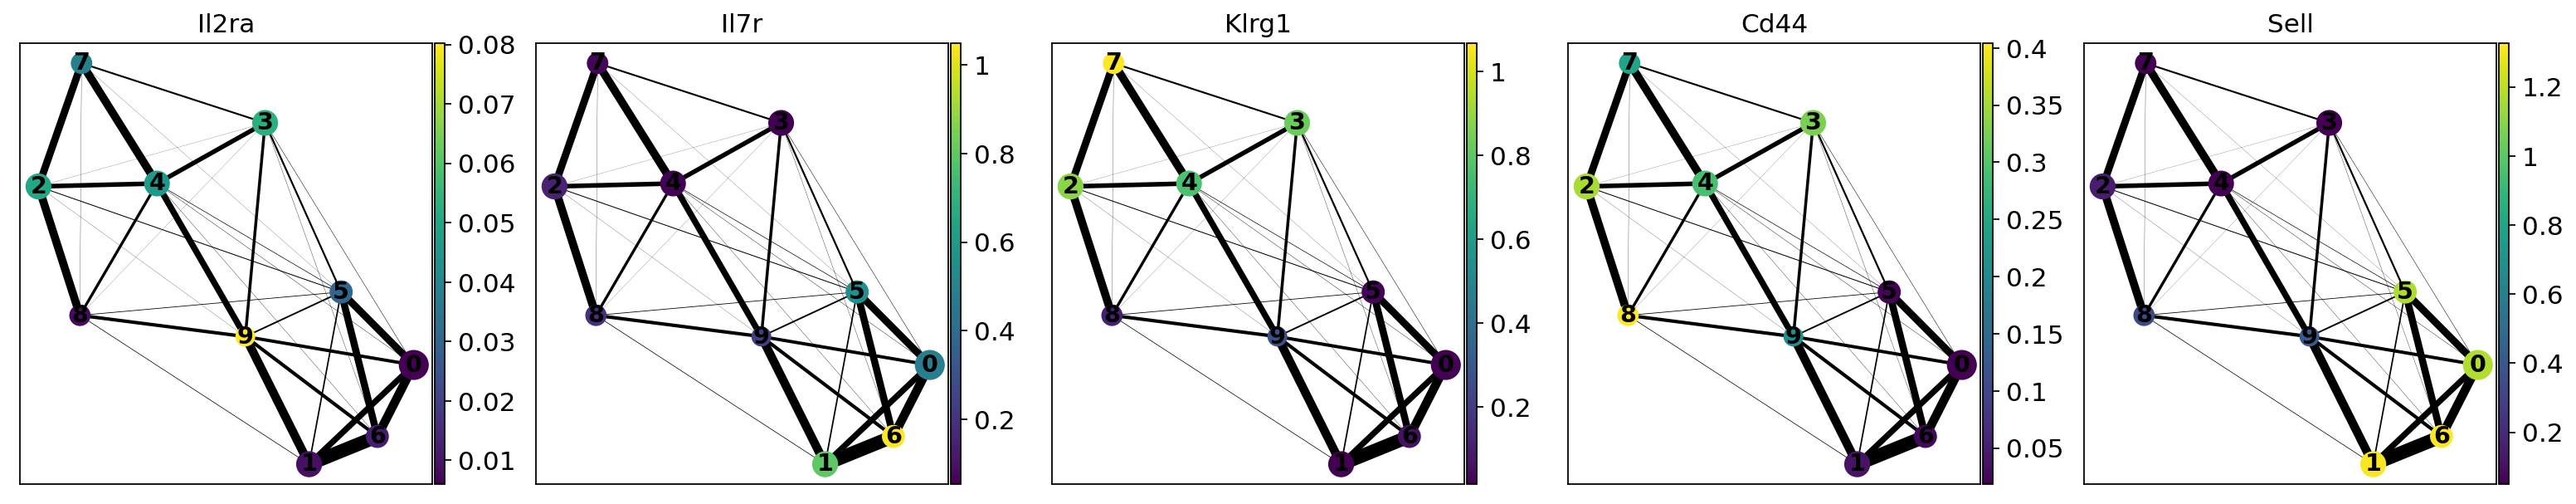

In [19]:
sc.pl.paga(adata, color=['Il2ra', 'Il7r','Klrg1','Cd44','Sell'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


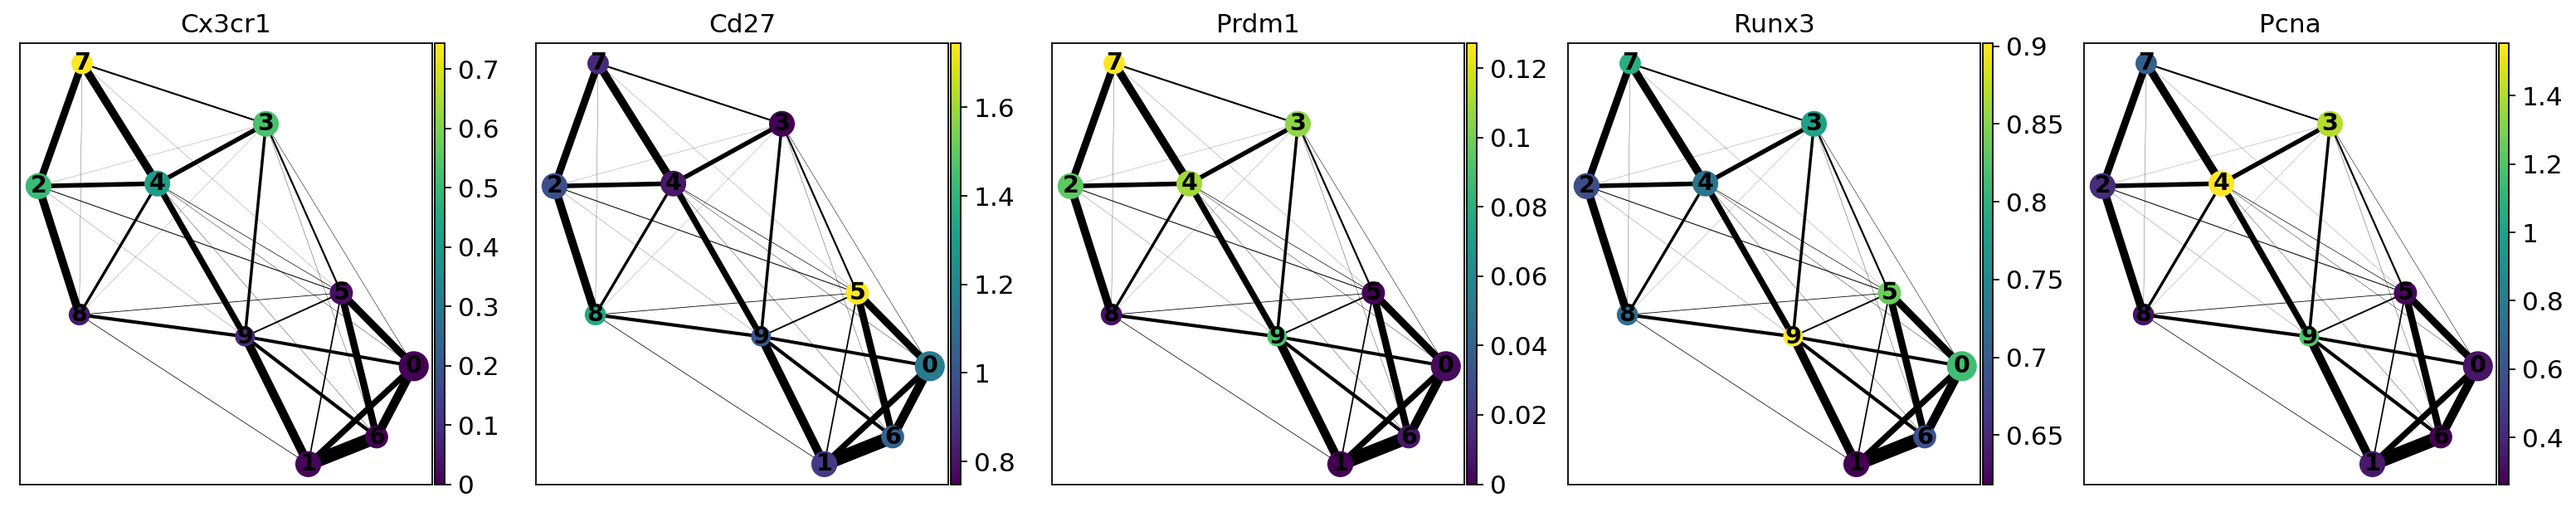

In [20]:
sc.pl.paga(adata, color=['Cx3cr1','Cd27', 'Prdm1', 'Runx3','Pcna'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


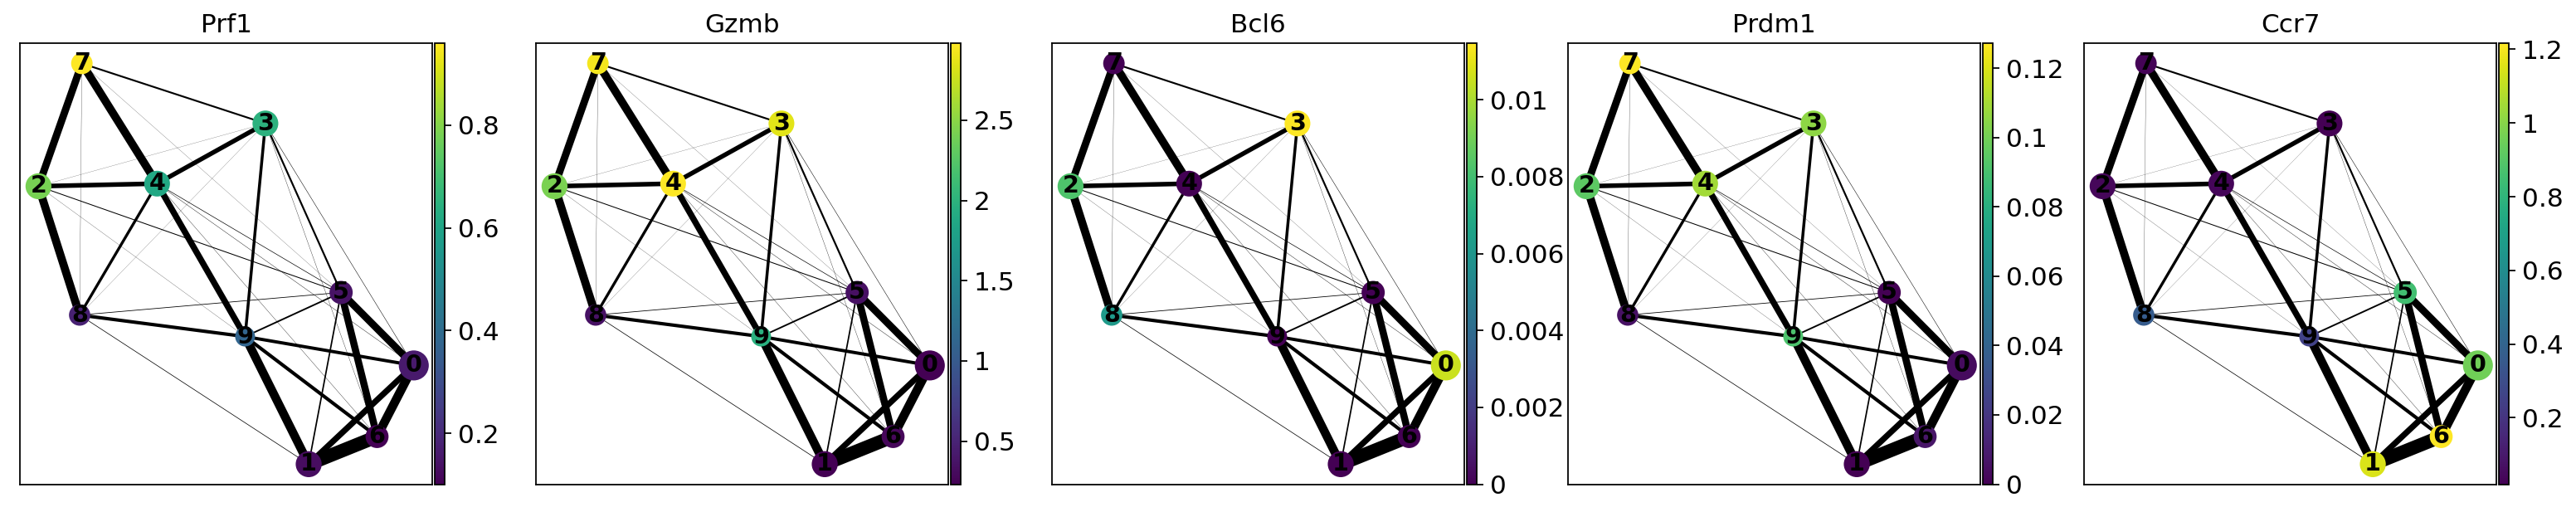

In [21]:
sc.pl.paga(adata, color=['Prf1', 'Gzmb', 'Bcl6','Prdm1','Ccr7'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


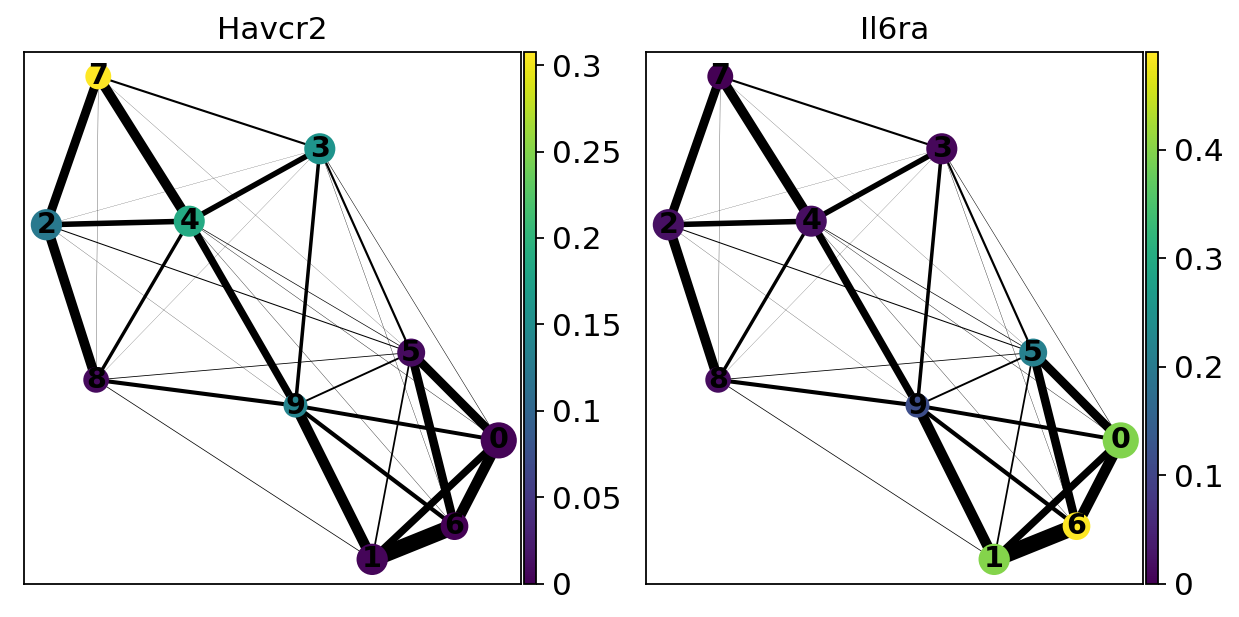

In [22]:
sc.pl.paga(adata, color=['Havcr2', 'Il6ra'])

### 1.1 Recomputing the embedding using PAGA-initialization

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:06)


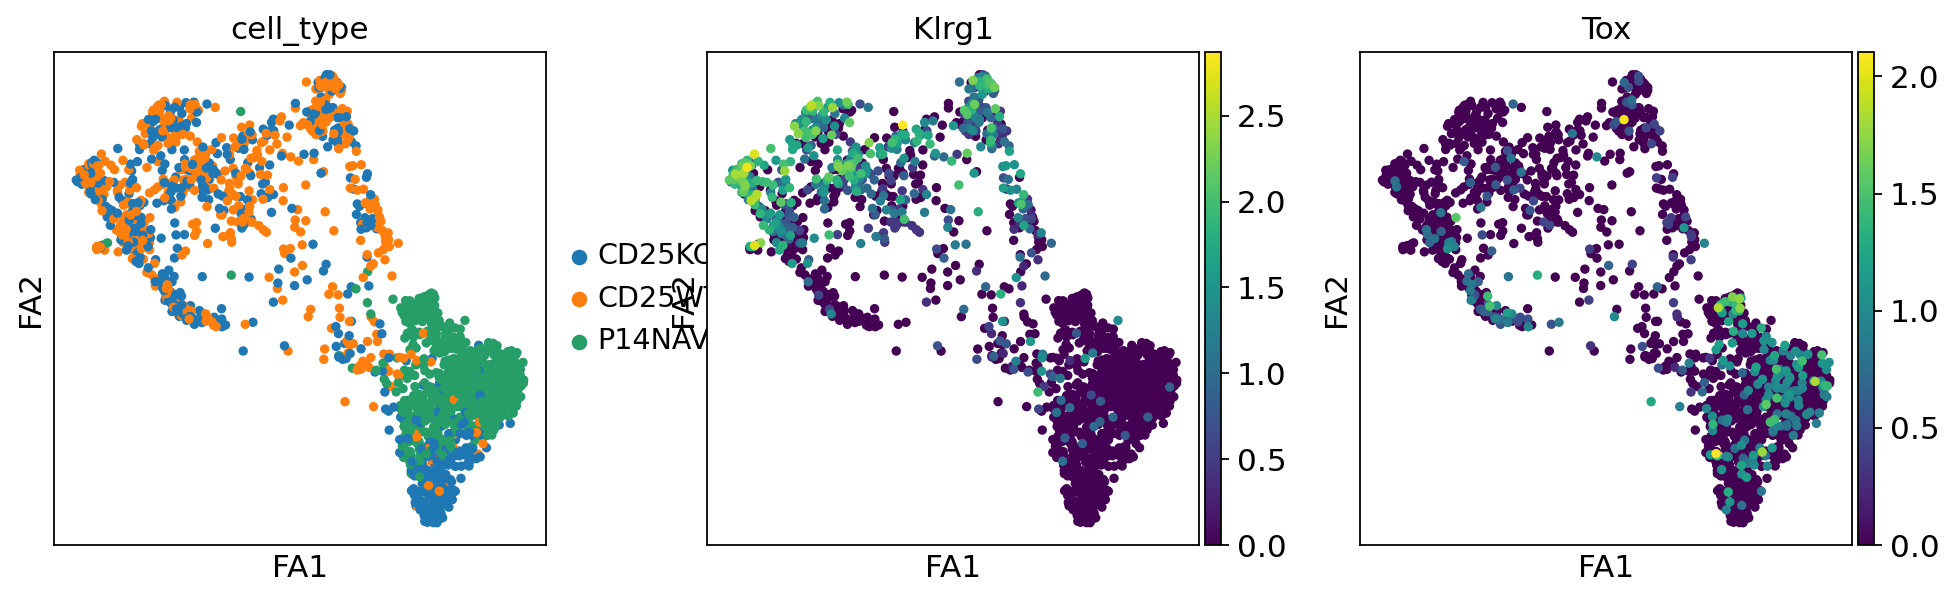

In [23]:
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['cell_type', 'Klrg1', 'Tox'])

In [24]:
adata.write("%s_paga_prePseudotime.h5ad"%outname_base)

In [25]:
adata

AnnData object with n_obs × n_vars = 1677 × 4549
    obs: 'cell_type', 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'draw_graph', 'neighbors', 'pca', 'louvain', 'paga', 'louvain_sizes', 'louvain_colors'
    obsm: 'X_draw_graph_fa', 'X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### 1.2 Reconstructing gene changes along PAGA paths for a given set of genes

In [26]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_paga_prePseudotime.h5ad"%outname_base)

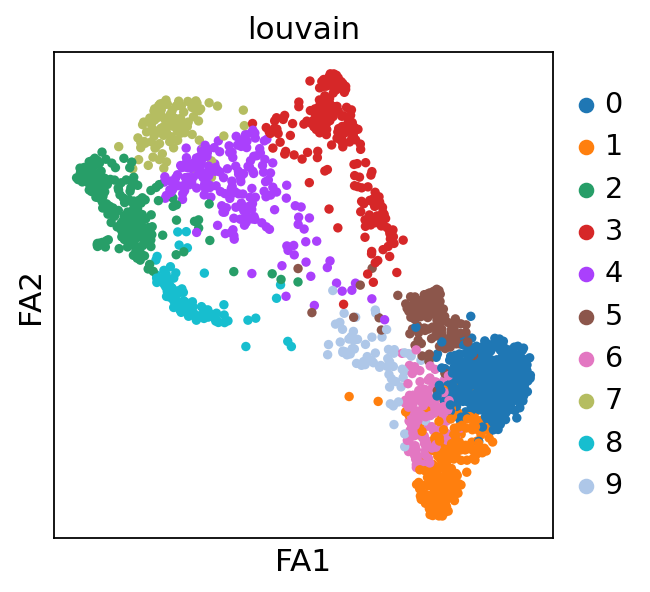

In [27]:
sc.pl.draw_graph(adata, color=['louvain'], save="louvain.png")

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9875165  0.9731545  0.94837356 0.9446743  0.93793005
     0.9352701  0.926674   0.92293566 0.90711015 0.89690745 0.8819907
     0.87559813 0.8710268  0.86028856]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


... storing 'celltype_louvain' as categorical


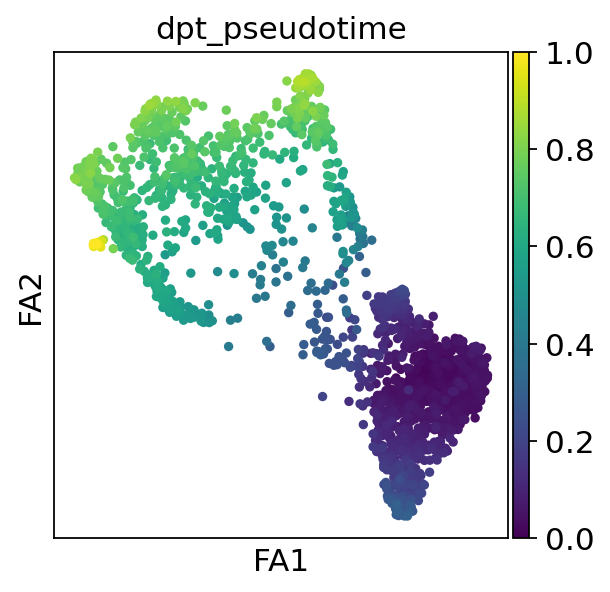

In [28]:
adata.obs['celltype_louvain'] = ["%s_%s"%(x, y) for index, (x,y) in 
                                 enumerate(zip(adata.obs['cell_type'].tolist(), adata.obs['louvain'].tolist()))]
adata.uns['iroot'] = np.flatnonzero(adata.obs['celltype_louvain'] == 'P14NAV_0')[0]

sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['dpt_pseudotime'])

### Save object

In [29]:
os.chdir(new_wk_dir)
adata.write("%s_paga.h5ad"%outname_base)

###----- Save whole object
adata.write_csvs("%s_paga"%outname_base)

writing .csv files to 1_IL2RAKO_paga


In [30]:
###----- Write Paga Connectivity
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga/paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga/paga_connect_tree.csv"%outname_base, sep=',')
paga_pos.to_csv("%s_paga/paga_pos.csv"%outname_base, sep=',')

-----

## 2. Summary & Average expression

In [31]:
os.chdir(new_wk_dir)
adata = sc.read_h5ad("%s_paga.h5ad"%outname_base)

### 2.0 Summary

In [32]:
sum_dir = new_wk_dir + "/0_sum"
Path(sum_dir).mkdir(parents=True, exist_ok=True)
os.chdir(sum_dir)

In [33]:
###----- Calculate cell type distrubution
cell_type_uniq = list(set(list(adata.obs['cell_type'])))
louvain_uniq = list(set(list(adata.obs['louvain'])))
louvain_uniq_use = list( range(0,(max([int(i) for i in louvain_uniq]) + 1)))
louvain_type_count_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
louvain_type_pctg_tb = pd.DataFrame(data = {'louvain': louvain_uniq_use})
for type_i in cell_type_uniq:
    #print(type_i)
    number_i = []
    pctg_i = []
    typ_i_louvain = list(adata.obs[adata.obs["cell_type"] == type_i]["louvain"])
    for i in louvain_uniq_use:
        #print(i)
        louvain_i_number = typ_i_louvain.count(str(i))
        louvain_i_pctg = float(louvain_i_number)*100/len(typ_i_louvain)
        number_i.append(louvain_i_number)
        pctg_i.append(louvain_i_pctg)
    louvain_type_count_tb[type_i] = number_i
    louvain_type_pctg_tb[type_i] = pctg_i
louvain_type_pctg_tb.to_csv("%s_Louvain--CellType_pctg.csv"%outname_base, index=False)
louvain_type_count_tb.to_csv("%s_Louvain--CellType_count.csv"%outname_base, index=False)

In [34]:
###----- Write Paga Connectivity
paga_connect = pd.DataFrame(adata.uns['paga']['connectivities'].A)
paga_connect_tree = pd.DataFrame(adata.uns['paga']['connectivities_tree'].A)
paga_pos = pd.DataFrame(adata.uns['paga']['pos'])

paga_connect.to_csv("%s_paga_connect.csv"%outname_base, sep=',')
paga_connect_tree.to_csv("%s_paga_connect_tree.csv"%outname_base, sep=',')
paga_pos.to_csv("%s_paga_pos.csv"%outname_base, sep=',')

In [35]:
###----- Obs average
adata.obs['counts_per_gene'] = adata.obs['n_counts'] / adata.obs['n_genes']
# Average by louvain
adata_obs_mean = adata.obs.groupby(['louvain']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean['louvain_new_label'] = ["P0", "P0.1", "P0.2", "P1", "P2", "P3", "P4", "P5", "P6", "P7"]
adata_obs_mean.to_csv("%s_obs_louvainAvg.csv"%outname_base)
adata_obs_mean

,n_genes,percent_mito,n_counts,dpt_pseudotime,counts_per_gene,louvain_new_label
louvain,,,,,,
0,1683.734908,0.024867,6228.409668,0.035648,3.667655,P0
6,1599.826446,0.025906,5886.603516,0.081596,3.644800,P0.1
5,1654.738095,0.023101,4764.000000,0.130868,2.718047,P0.2
1,1642.611650,0.018142,6761.917480,0.158778,4.075308,P1
9,4003.390625,0.024384,24539.500000,0.220081,5.974900,P2
8,2828.586207,0.027721,12735.666992,0.552099,4.444867,P3
4,3232.525253,0.025830,14805.090820,0.628313,4.499808,P4
3,3533.750000,0.025835,17062.605469,0.682181,4.738747,P5
2,2301.151961,0.024863,8605.587891,0.704129,3.661917,P6


In [36]:
# Average by cell type
adata_obs_mean = adata.obs.groupby(['cell_type']).mean()
adata_obs_mean = adata_obs_mean.sort_values(by="dpt_pseudotime")
adata_obs_mean.to_csv("%s_obs_ctAvg.csv"%outname_base)
adata_obs_mean

,n_genes,percent_mito,n_counts,dpt_pseudotime,counts_per_gene
cell_type,,,,,
P14NAV,1668.788401,0.025090,5949.498535,0.071717,3.500839
CD25KO,2531.155556,0.022807,11173.064453,0.477916,4.245031
CD25WT,3002.739479,0.024919,13854.386719,0.607513,4.385092


### 2.1 Summary plots -- louvain

<AxesSubplot:xlabel='louvain', ylabel='n_genes'>

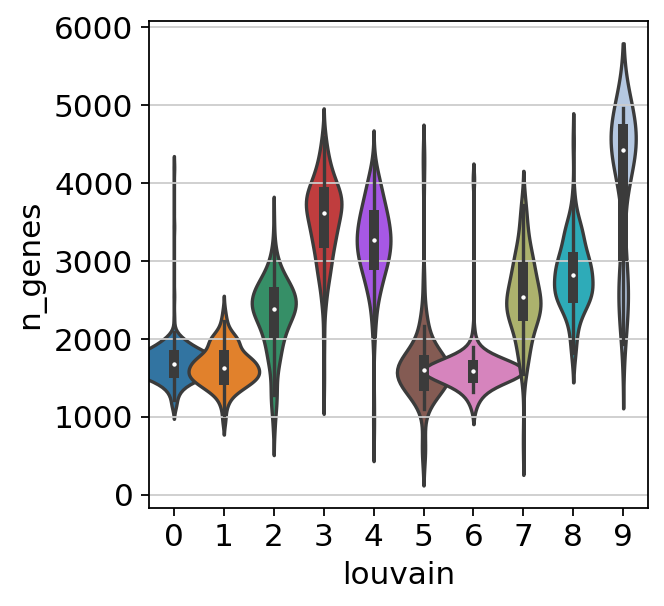

In [37]:
sns.violinplot(x="louvain", y="n_genes", data=adata.obs, width = 2)

<AxesSubplot:xlabel='louvain', ylabel='n_counts'>

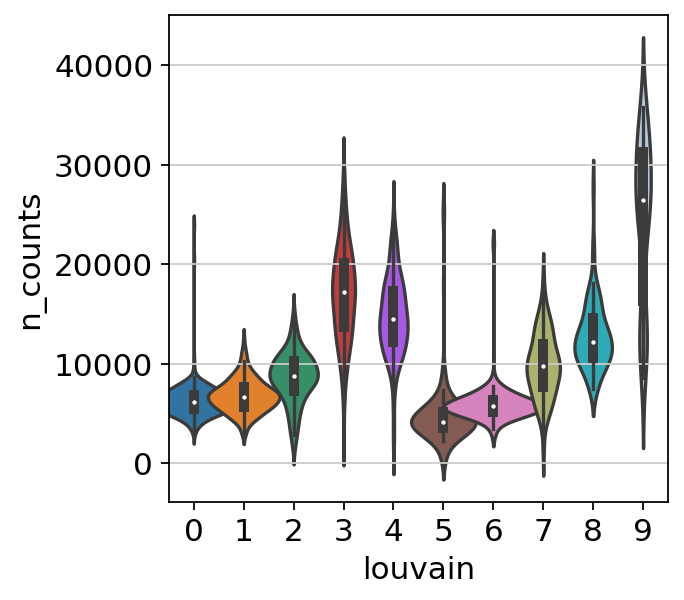

In [38]:
sns.violinplot(x="louvain", y="n_counts", data=adata.obs, width = 2)

<AxesSubplot:xlabel='louvain', ylabel='percent_mito'>

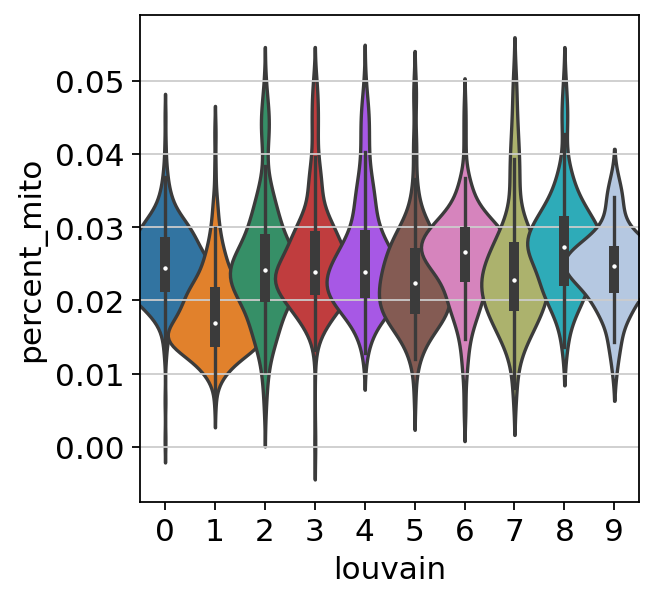

In [39]:
sns.violinplot(x="louvain", y="percent_mito", data=adata.obs, width = 2)

### 2.2 Summary plots -- cell type

<AxesSubplot:xlabel='cell_type', ylabel='n_genes'>

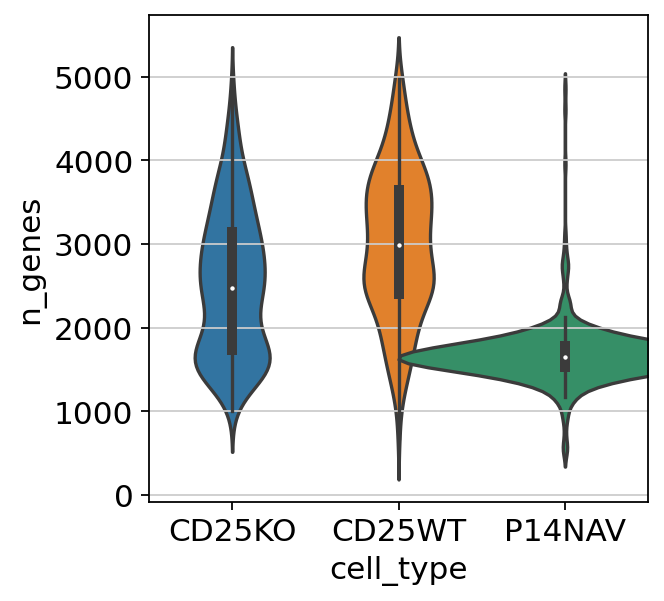

In [40]:
sns.violinplot(x="cell_type", y="n_genes", data=adata.obs, width = 2)

<AxesSubplot:xlabel='cell_type', ylabel='n_counts'>

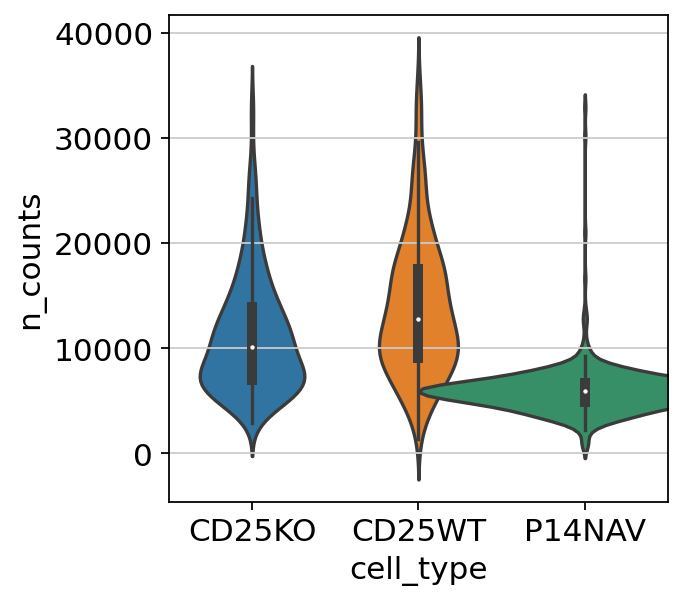

In [41]:
sns.violinplot(x="cell_type", y="n_counts", data=adata.obs, width = 2)

<AxesSubplot:xlabel='cell_type', ylabel='percent_mito'>

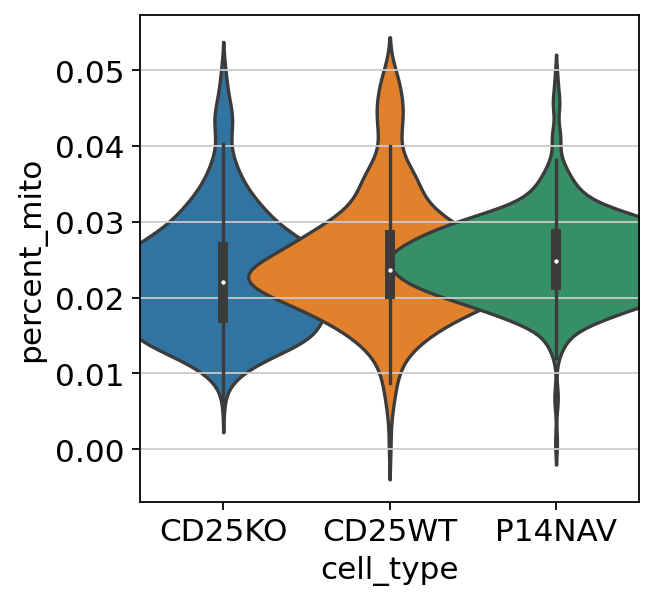

In [42]:
sns.violinplot(x="cell_type", y="percent_mito", data=adata.obs, width = 2)

### 2.1 Average expression

In [43]:
sum_dir = new_wk_dir + "/1_avg_expr"
Path(sum_dir).mkdir(parents=True, exist_ok=True)
os.chdir(sum_dir)

In [44]:
adata.obs['louvain_celltype'] = ["%s_%s"%(str(y), str(x)) for 
                                 index, (x,y) in enumerate(zip(adata.obs['cell_type'].values, adata.obs['louvain'].values))]

use_cols = ["cell_type", "louvain", "louvain_celltype"] # 'cell_type', 'louvain', 'louvain_celltype'

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0)
    use_key_mean_df.to_csv("%s_mean_scaled_expr.csv"%use_key)
    use_key_z_df.to_csv("%s_mean_scaled_expr_z.csv"%use_key)

*Calculate average for CD25KO or WT together with Naive*

In [45]:
adata.obs['louvain_celltype_CD25KO_Naive'] = [x.replace("P14NAV", "KO-NAV") if "NAV" in x else x 
                                              for x in adata.obs['louvain_celltype']]
adata.obs['louvain_celltype_CD25KO_Naive'] = [x.replace("CD25KO", "KO-NAV") if "CD25KO" in x else x 
                                              for x in adata.obs['louvain_celltype_CD25KO_Naive']]
adata.obs['louvain_celltype_CD25KO_Naive'] = ["other" if "WT" in x else x 
                                              for x in adata.obs['louvain_celltype_CD25KO_Naive']]

use_cols = ['louvain_celltype_CD25KO_Naive']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df
use_key_z_df_all = use_key_z_df

adata.obs['louvain_celltype_CD25WT_Naive'] = [x.replace("P14NAV", "WT-NAV") if "NAV" in x else x 
                                              for x in adata.obs['louvain_celltype']]
adata.obs['louvain_celltype_CD25WT_Naive'] = [x.replace("CD25WT", "WT-NAV") if "CD25WT" in x else x 
                                              for x in adata.obs['louvain_celltype_CD25WT_Naive']]
adata.obs['louvain_celltype_CD25WT_Naive'] = ["other" if "KO" in x else x 
                                              for x in adata.obs['louvain_celltype_CD25WT_Naive']]

use_cols = ['louvain_celltype_CD25WT_Naive']

expr_df = pd.DataFrame(adata.X)
expr_df.index = adata.obs.index
expr_df.columns = adata.var.index
expr_df.columns.name = ''

for use_key in use_cols:
    use_key_types = np.unique(adata.obs[use_key])
    use_key_df = expr_df.join(adata.obs[[use_key]])
    use_key_mean_df = use_key_df.groupby(use_key).mean().T
    use_key_mean_df.columns.name = ""
    use_key_mean_df.index.name = "gene_name"
    use_key_z_df = use_key_mean_df.apply(lambda x: stats.zscore(x), axis=0)
    del use_key_z_df['other']
    del use_key_mean_df['other']
use_key_mean_df_all = use_key_mean_df_all.join(use_key_mean_df)
use_key_z_df_all = use_key_z_df_all.join(use_key_z_df)

use_key_mean_df_all.to_csv("louvain_celltype_general_withNAV_mean_scaled_expr.csv")
use_key_z_df_all.to_csv("louvain_celltype_general_withNAV_mean_scaled_expr_z.csv")